In [1]:
import sys
sys.path.insert(0, '/tf/utils/')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pesq import pesq
import pystoi
from scipy.signal import lfilter, wiener
import scipy.linalg 
from tqdm import tqdm

from utils import load_wav, calculate_snr, itakura_distortion, performance, preemphasis
from sound import Sound
from batch import DataGenerator

from multiprocessing import Pool, cpu_count

In [3]:
base_shape_size = 8000

In [4]:
# carrega sons de ruido e sons de voz
sound_base = Sound('../Dados/Base/', '../Dados/ESC-50-master/audio/', base_shape_size)

Loading noise files: 100%|██████████| 2000/2000 [00:09<00:00, 219.49it/s]


In [5]:
# Parâmetros do sistema
order = 16  # Ordem da análise LPC
window_size = 250  # Tamanho da janela
sample_rate = 8000  # Taxa de amostragem (exemplo)

In [6]:
data_generator = DataGenerator(sound_base.train_X, sound_base.noise_sounds)

In [7]:
# Adicionar filtro de pré-ênfase no sinal para obter valores mais adequados de coeficientes LPC

def lpc_analysis(signal_segment, order, noise_estimation_order=100):
    # Aplicar janelamento de Hamming
    windowed_signal = signal_segment * np.hamming(len(signal_segment))
    
    # Calcular os coeficientes LPC usando autocorrelação
    autocorr = np.correlate(windowed_signal, windowed_signal, mode='full')
    r = autocorr[len(autocorr) // 2:len(autocorr) // 2 + order + 1]
    
    # Estimar o espectro de potência do ruído durante intervalos de não fala
    noise_periodogram = np.zeros(order + 1)
    for i in range(len(signal_segment) // noise_estimation_order):
        noise_segment = signal_segment[i * noise_estimation_order:(i + 1) * noise_estimation_order]
        noise_autocorr = np.correlate(noise_segment, noise_segment, mode='full')
        noise_periodogram += noise_autocorr[len(noise_autocorr) // 2:len(noise_autocorr) // 2 + order + 1]
    
    noise_periodogram /= len(signal_segment) // noise_estimation_order
    
    # Subtrair o espectro de potência do ruído do espectro de potência do sinal corrompido
    adjusted_r = r - noise_periodogram
    
    # Usar a função toeplitz para realizar a decomposição de Levinson-Durbin
    A = scipy.linalg.solve_toeplitz((adjusted_r[:-1], adjusted_r[1:]), -adjusted_r[1:])
    
    # Calcular o erro de predição linear (residual)
    residual = signal_segment - scipy.signal.lfilter(np.hstack([1, -A]), 1, signal_segment)
    
    # Calcular a variância do erro de predição linear (residual)
    var_residual = np.var(residual)

    return A, np.sqrt(var_residual), adjusted_r

In [8]:
def build_matrices(A, window_size):
    Ak = np.zeros((order, order))
    Ak[:, 0] = -A
    Ak[:-1, 1:] = np.eye(order - 1)

    H = np.zeros((1, order))
    H[0, 0] = 1.0

    return Ak, H

In [9]:
def kalman_filter(signal, Ak, H, Q, R):
    x_hat = np.zeros(order)  # Estado estimado
    P = np.eye(order)  # Covariância estimada

    filtered_signal = []

    for sample in signal:
        # Atualização temporal (Predição)
        x_hat = np.dot(Ak, x_hat)
        P = np.dot(np.dot(Ak, P), Ak.T) + Q

        # Atualização de mensuração (Correção)
        K = np.dot(np.dot(P, H.T), np.linalg.inv(np.dot(np.dot(H, P), H.T) + R))
        x_hat = x_hat + np.dot(K, (sample - np.dot(H, x_hat)))
        P = P - np.dot(np.dot(K, H), P)

        filtered_signal.append(x_hat[0])  # Apenas a primeira componente é o sinal estimado

    return np.array(filtered_signal)

In [10]:
def combine_filtered_signal(filtered_signals, window_size, hop_size):
    total_length = (len(filtered_signals) - 1) * hop_size + window_size
    combined_signal = np.zeros(total_length)

    for i, window_signal in enumerate(filtered_signals):
        start_idx = i * hop_size
        end_idx = start_idx + len(window_signal)
        combined_signal[start_idx:end_idx] += window_signal

    # Calcular os pesos para a média ponderada
    weights = np.zeros(total_length)

    for i, window_signal in enumerate(filtered_signals):
        start_idx = i * hop_size
        end_idx = start_idx + len(window_signal)
        weights[start_idx:end_idx] += 1.0

    weights[weights == 0] = 1.0  # Evitar divisão por zero
    combined_signal /= weights  # Aplicar a média ponderada

    return combined_signal

In [28]:
def process_signal(signal, window_size, order, sample_rate, SNR_dB=10.):
    filtered_signal = []

    for i in range(0, len(signal), window_size):
        window_samples = signal[i:i+window_size]

        # Aplica o filtro de pré-ênfase
        # emphasized_signal = preemphasis(window_samples, alpha=0.8)
        
        # Realizar análise LPC e construir as matrizes Ak e H
        A, sigma, _ = lpc_analysis(window_samples, order)
        Ak, H = build_matrices(A, len(window_samples))

        # Calcular a variância do erro de aquisição R com base no SNR linear
        SNR_linear = 10.**(SNR_dB / 10.)
        Rx = 1. / SNR_linear
        
        # Calcular Q e R (assumindo que não mudam dentro da janela)
        Q = np.eye(order) * sigma  # Variância do erro de predição
        R = np.eye(1) * Rx  # Variância do erro de aquisição

        # Aplicar o filtro de Kalman na janela
        filtered_window = kalman_filter(window_samples, Ak, H, Q, R)
        filtered_signal.extend(filtered_window)

    return np.array(filtered_signal)

In [29]:
def process_batch(args):
    x_batch, y_batch, SNR_dB_batch, window_size, order, sample_rate = args
    filtered_batch = [process_signal(noisy_signal, window_size, order, sample_rate, SNR_dB=SNR_dB) for noisy_signal, SNR_dB in zip(x_batch, SNR_dB_batch)]
    
    pesq_scores = [pesq(8000, clean, filtered.reshape(-1), 'nb') for clean, filtered in zip(y_batch, filtered_batch)]
    stoi_scores = [pystoi.stoi(clean, filtered, 8000) for clean, filtered in zip(y_batch, filtered_batch)]
    snr_scores = [calculate_snr(clean, filtered) for clean, filtered in zip(y_batch, filtered_batch)]
    ID_scores = [itakura_distortion(clean, filtered, window_size, order) for clean, filtered in zip(y_batch, filtered_batch)]
    
    return pesq_scores, stoi_scores, snr_scores, ID_scores

In [30]:
batch_num = 50
df_resultado = pd.DataFrame()

In [31]:
num_processes = cpu_count()  # Usar o número de núcleos da CPU
    
with Pool(processes=num_processes) as pool:
    results = []
    
    for _ in tqdm(range(batch_num)):
        x_batch, y_batch, metrics_batch_df = next(data_generator.generate_sample_metrics(window_size, order, batch_size=128))
        SNR_dB_batch = metrics_batch_df['SNR']
        
        args = (x_batch, y_batch, SNR_dB_batch, window_size, order, sample_rate)
        result = pool.apply_async(process_batch, (args,))
        results.append((result, metrics_batch_df))
    
    df_resultado = pd.DataFrame()
    
    for result, metrics_batch_df in results:
        pesq_scores, stoi_scores, snr_scores, ID_scores = result.get()
        metrics_batch_df['PESQ (Filtered)'] = pesq_scores
        metrics_batch_df['STOI (Filtered)'] = stoi_scores
        metrics_batch_df['SNR (Filtered)'] = snr_scores
        metrics_batch_df['ID (Filtered)'] = ID_scores
        
        df_resultado = pd.concat([df_resultado, metrics_batch_df], ignore_index=True)

100%|██████████| 50/50 [10:12<00:00, 12.25s/it]


In [24]:
# for _ in tqdm(range(batch_num)):
#     x_batch, y_batch, metrics_batch_df = next(data_generator.generate_sample_metrics(window_size, order, batch_size=128))
                
#     # Aplica o filtro de Kalman aos sinais ruidosos
#     filtered_batch = [process_signal(noisy_signal, window_size, order, sample_rate, SNR_dB=SNR_dB) for noisy_signal, SNR_dB in zip(x_batch, metrics_batch_df['SNR'])]
    
#     # Calcula as métricas para os sinais filtrados
#     pesq_scores = [pesq(8000, clean, filtered.reshape(-1), 'nb') for clean, filtered in zip(y_batch, filtered_batch)]
#     stoi_scores = [pystoi.stoi(clean, filtered, 8000) for clean, filtered in zip(y_batch, filtered_batch)]
#     snr_scores = [calculate_snr(clean, filtered) for clean, filtered in zip(y_batch, filtered_batch)]
#     ID_scores = [itakura_distortion(clean, filtered, window_size, order) for clean, filtered in zip(y_batch, filtered_batch)]
    
#     # Adiciona as métricas dos sinais filtrados ao DataFrame
#     metrics_batch_df['PESQ (Filtered)'] = pesq_scores
#     metrics_batch_df['STOI (Filtered)'] = stoi_scores
#     metrics_batch_df['SNR (Filtered)'] = snr_scores
#     metrics_batch_df['ID (Filtered)'] = ID_scores

#     df_resultado = pd.concat([df_resultado, metrics_batch_df], ignore_index=True)

In [25]:
df_resultado

,SNR Ruído aditivo,SNR Ruído Gauss Branco,PESQ,STOI,SNR,ID,PESQ (Filtered),STOI (Filtered),SNR (Filtered),ID (Filtered)
0,16.0,19.0,2.307564,0.949869,14.147222,0.124686,2.483967,0.936530,1.768515,0.765661
1,4.0,15.0,1.550540,0.920666,3.584875,0.088023,1.508764,0.903852,1.108077,1.084820
2,10.0,20.0,1.892621,0.838517,9.557638,0.236351,1.880874,0.838795,1.361152,1.175016
3,2.0,24.0,1.271618,0.652415,2.043442,0.146070,1.317275,0.656588,1.124302,0.784204
4,18.0,16.0,1.824520,0.794100,13.803558,0.271305,1.787941,0.781013,1.655996,1.136621
...,...,...,...,...,...,...,...,...,...,...
6393,4.0,24.0,1.573173,0.654902,4.160840,-0.226478,1.476696,0.632357,0.219027,0.491632
6394,3.0,22.0,1.432648,0.728195,2.905570,0.758271,1.550834,0.699269,-1.867842,1.756967
6395,19.0,19.0,1.916911,0.870480,15.962801,0.250362,1.919998,0.869462,1.710768,1.215019
6396,-2.0,17.0,1.626100,0.611703,-2.129259,-0.151739,1.737689,0.554563,-1.839289,0.671084


In [26]:
df_resultado.describe()

,SNR Ruído aditivo,SNR Ruído Gauss Branco,PESQ,STOI,SNR,ID,PESQ (Filtered),STOI (Filtered),SNR (Filtered),ID (Filtered)
count,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000
mean,7.123476,19.474992,1.908210,0.804946,6.504478,0.334860,1.895360,0.784531,0.260413,1.162877
std,7.248147,2.856242,0.489242,0.138058,6.390488,0.338556,0.496617,0.146025,2.086511,0.410352
min,-5.000000,15.000000,1.042569,0.000010,-5.212113,-0.544960,1.056344,0.000010,-10.391601,0.042298
25%,1.000000,17.000000,1.531549,0.723620,0.944611,0.110376,1.516740,0.696380,-0.241882,0.884821
50%,7.000000,20.000000,1.834655,0.836006,6.886963,0.235262,1.820577,0.819197,1.184016,1.091774
75%,13.000000,22.000000,2.193120,0.915227,12.267929,0.470840,2.171819,0.900497,1.614622,1.378424
max,19.000000,24.000000,4.360335,0.997409,17.892792,2.665546,4.192013,0.993128,1.915465,3.571800


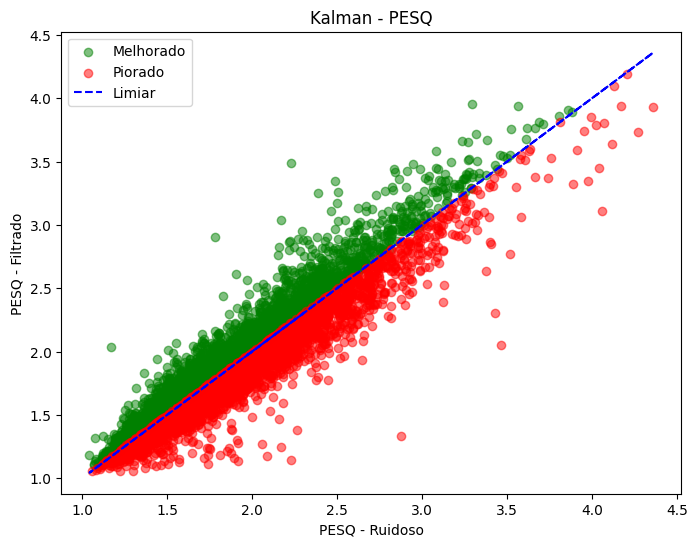

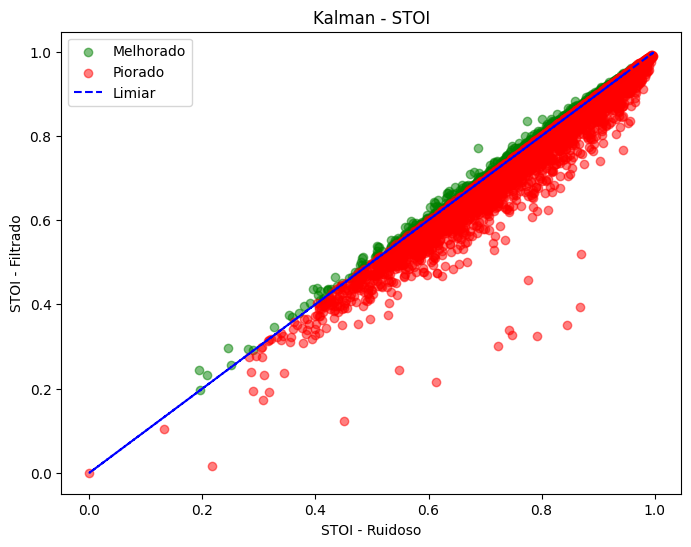

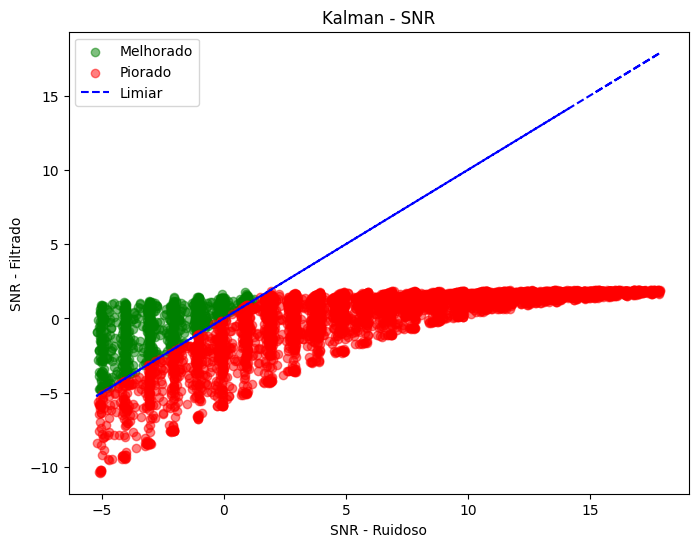

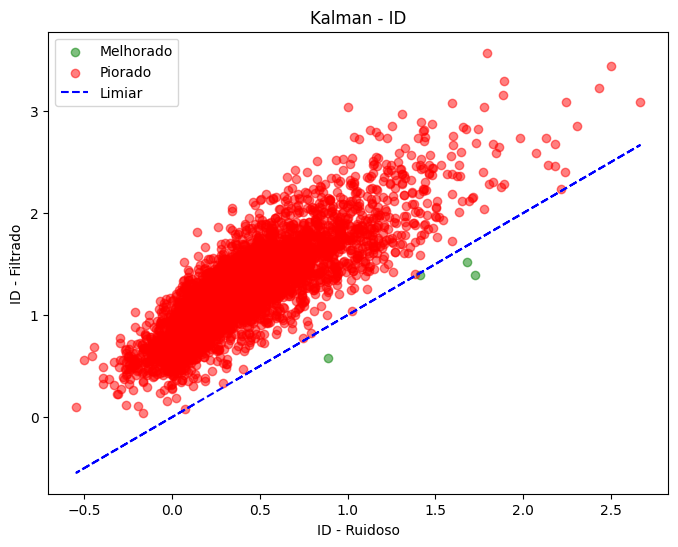

In [27]:
performance(df_resultado, 'Kalman')